In [ ]:
!pip install synapticflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import required libraries

In [ ]:
import os
import math
import torch
import numpy as np
import pandas as pd
import synapticflow as sf
from torch import nn, optim
import matplotlib.pyplot as plt
from synapticflow.network import neural_populations as neup


## Train and Test Dataset

In [ ]:
train_set = '/content/drive/MyDrive/asg2/train'
test_set = '/content/drive/MyDrive/asg2/test'

## Load the training data

In [ ]:
class InData(torch.utils.data.Dataset):
  def __init__(self, path):
    self.data = pd.read_csv(path)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    sample = self.data.loc[idx].values
    return torch.tensor(sample)

class OutData(torch.utils.data.Dataset):
  def __init__(self, path) -> None:
     super().__init__()
     self.data = pd.read_csv(path)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    sample = self.data.loc[idx].values
    return torch.tensor(sample)

## Some useful methods

In [ ]:
import matplotlib.pyplot as plt # import the necessary library for plotting

def plot_I(dataframe):
    """
    Plots the input current data from a given pandas dataframe.

    Args:
        dataframe: A pandas dataframe containing the input current data.

    Returns:
        None
    """
    fig = plt.figure(figsize=(8, 5)) # create a new figure object with a specific size
    plt.plot(dataframe.iloc[400:2500,0], dataframe.iloc[400:2500,1], c='r') # plot the relevant data from the dataframe
    plt.xlabel("time (mS)") # set the label for the x-axis
    plt.ylabel("input current (pA)") # set the label for the y-axis
    plt.grid() # add a grid to the plot
    plt.title("Real Input Current") # set the title of the plot
    plt.show() # display the plot

def plot_s(dataframe):
    """
    Plots the spike points data from a given pandas dataframe.

    Args:
        dataframe: A pandas dataframe containing the spike points data.

    Returns:
        None
    """
    spike_points = dataframe.to_numpy() # convert the dataframe to a numpy array
    fig = plt.figure(figsize=(8,5)) # create a new figure object with a specific size
    plt.scatter(spike_points[:,0],spike_points[:,1],marker='|',c='b',s=500) # plot the spike points as a scatter plot
    plt.xlabel("time (mS)") # set the label for the x-axis
    plt.yticks(ticks=[1],labels=['spike']) # set the label for the y-axis
    plt.grid() # add a grid to the plot
    plt.title("Spike Points Diagram") # set the title of the plot
    plt.show() # display the plot

def plot_v(dataframe):
    """
    Plots the membrane potential data from a given pandas dataframe.

    Args:
        dataframe: A pandas dataframe containing the membrane potential data.

    Returns:
        None
    """
    fig = plt.figure(figsize=(13, 1)) # create a new figure object with a specific size
    plt.plot(dataframe.iloc[400:3000,0], dataframe.iloc[400:3000,2], c='g') # plot the relevant data from the dataframe
    plt.xlabel("time (mS)") # set the label for the x-axis
    plt.ylabel("membrane potential (mV)") # set the label for the y-axis
    plt.grid() # add a grid to the plot
    plt.title("Real Membrane Plot") # set the title of the plot
    plt.show() # display the plot

def input_data(dataframe):
    """
    Loads input data from a given pandas dataframe into PyTorch tensors.

    Args:
        dataframe: A pandas dataframe containing the input data.

    Returns:
        A tuple of PyTorch tensors containing the time, input current, and real voltage data, respectively.
    """
    current = torch.tensor(dataframe.iloc[:, 1].to_numpy()) # extract the input current data from the dataframe and convert to PyTorch tensor
    real_voltage = torch.tensor(dataframe.iloc[:, 2].to_numpy()) # extract the real voltage data from the dataframe and convert to PyTorch tensor
    time = torch.tensor(dataframe.iloc[:, 0].to_numpy()) # extract the time data from the dataframe and convert to PyTorch tensor

    return time, current, real_voltage # return a tuple of the three PyTorch tensors


def spikes_data(dataframe):
    """
    Loads spike time data from a given pandas dataframe into a PyTorch tensor.

    Args:
        dataframe: A pandas dataframe containing the spike time data.

    Returns:
        A PyTorch tensor containing the spike time data.
    """
    real_spikes_time = torch.tensor(dataframe.iloc[:, 0].to_numpy()) # extract the spike time data from the dataframe and convert to PyTorch tensor

    return real_spikes_time # return the PyTorch tensor

def our_acc(model_spikes, real_spikes):
    """
    Computes the accuracy of a model's predicted spike times compared to the ground truth spike times.

    Args:
        model_spikes: A list of integers representing the predicted spike times.
        real_spikes: A list of integers representing the ground truth spike times.

    Returns:
        The accuracy of the model's spike predictions as a float between 0 and 1.
    """
    machings = 0 # initialize a variable to count the number of matching spikes between the model's predictions and the ground truth
    for s in real_spikes: # iterate over each spike in the ground truth data
        if (s in model_spikes) or (s+1 in model_spikes) or (s-1 in model_spikes) or (s+2 in model_spikes) or (s-2 in model_spikes): # check if the spike or any spike within a certain range is present in the model's predictions
            machings += 1 # if a matching spike is found, increment the count of matching spikes

    print(f'machings: {machings}\t real_spikes: {len(real_spikes)}\t model_spikes: {len(model_spikes)}') # print the number of matching spikes, the total number of ground truth spikes, and the total number of model predictions

    # calculate theaccuracy of the model's predictions based on the number of matching spikes and the total number of spikes predicted and ground truth spikes
    acc = (machings - 0.1*len(real_spikes)) / (len(model_spikes) + len(real_spikes))
    return acc

def running_model(model, current, real_spikes, time):
    """
    Runs the given model on the input data and compares its output to the given spike data.

    Args:
        model: The model to be run.
        current: A PyTorch tensor containing the input current data.
        real_spikes: A PyTorch tensor containing the real spike time data.
        time: A PyTorch tensor containing the time data.

    Returns:
        None
    """
    modelSpike = torch.empty(0) # create an empty tensor to store the spike times predicted by the model
    modelVoltage = torch.empty(0) # create an empty tensor to store the voltage values predicted by the model

    for i in range(len(current)):
        model.forward(current[i]) # run the model on the current value
        if model.s: # if the model predicts a spike, append the current time to the modelSpike tensor
            modelSpike = torch.cat((modelSpike, torch.tensor([time[i]])))
        modelVoltage = torch.cat((modelVoltage, model.v)) # append the predicted voltage value to the modelVoltage tensor

    acc = our_acc(modelSpike, real_spikes) # calculate the accuracy of the model's spike predictions
    print(f'accuracy: {acc}') # print the accuracy to the console


def load_and_visualize (idx, start=0, end=5000) :
    input_path = os.path.join(train_set, f'input_{idx}.csv')
    output_path = os.path.join(test_set, f'input_{idx}.csv')

    in_df = pd.read_csv(input_path)
    out_df = pd.read_csv(output_path)

    time, current, potential = input_data(in_df)
    spikes = spikes_data(out_df)
    spike1 = out_df.iloc[0,0]
    init_potential = potential[0]
    max_potential, max_potential_time = torch.max(potential), torch.argmax(potential)
    print(f'first spike: {spike1} s \t initial potential:{init_potential} mV \t max pot and time: {max_potential} mV and {max_potential_time} ms')

    plt.figure(figsize=(20, 12))

    ax1 = plt.subplot(211)
    plt.plot(time[start:end], current[start:end])

    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(time[start:end], potential[start:end])

    ax1.set_ylabel('current(pA)')
    ax1.set_xlabel('time(ms)')
    ax2.set_ylabel('potential(mV)')
    ax2.set_xlabel('time(ms)')

    plt.show()

    return time, current, potential, spikes

## Visualizing the input and the output of the dataset & Create the neuron model

In [ ]:
model = neup.AQLIFPopulation(n=1, rest_pot=-60.00, threshold=-70.00, R=0.02, dt=1)

first spike: 0.0 s 	 initial potential:-63.3672 mV 	 max pot and time: 46.3203 mV and 549 ms


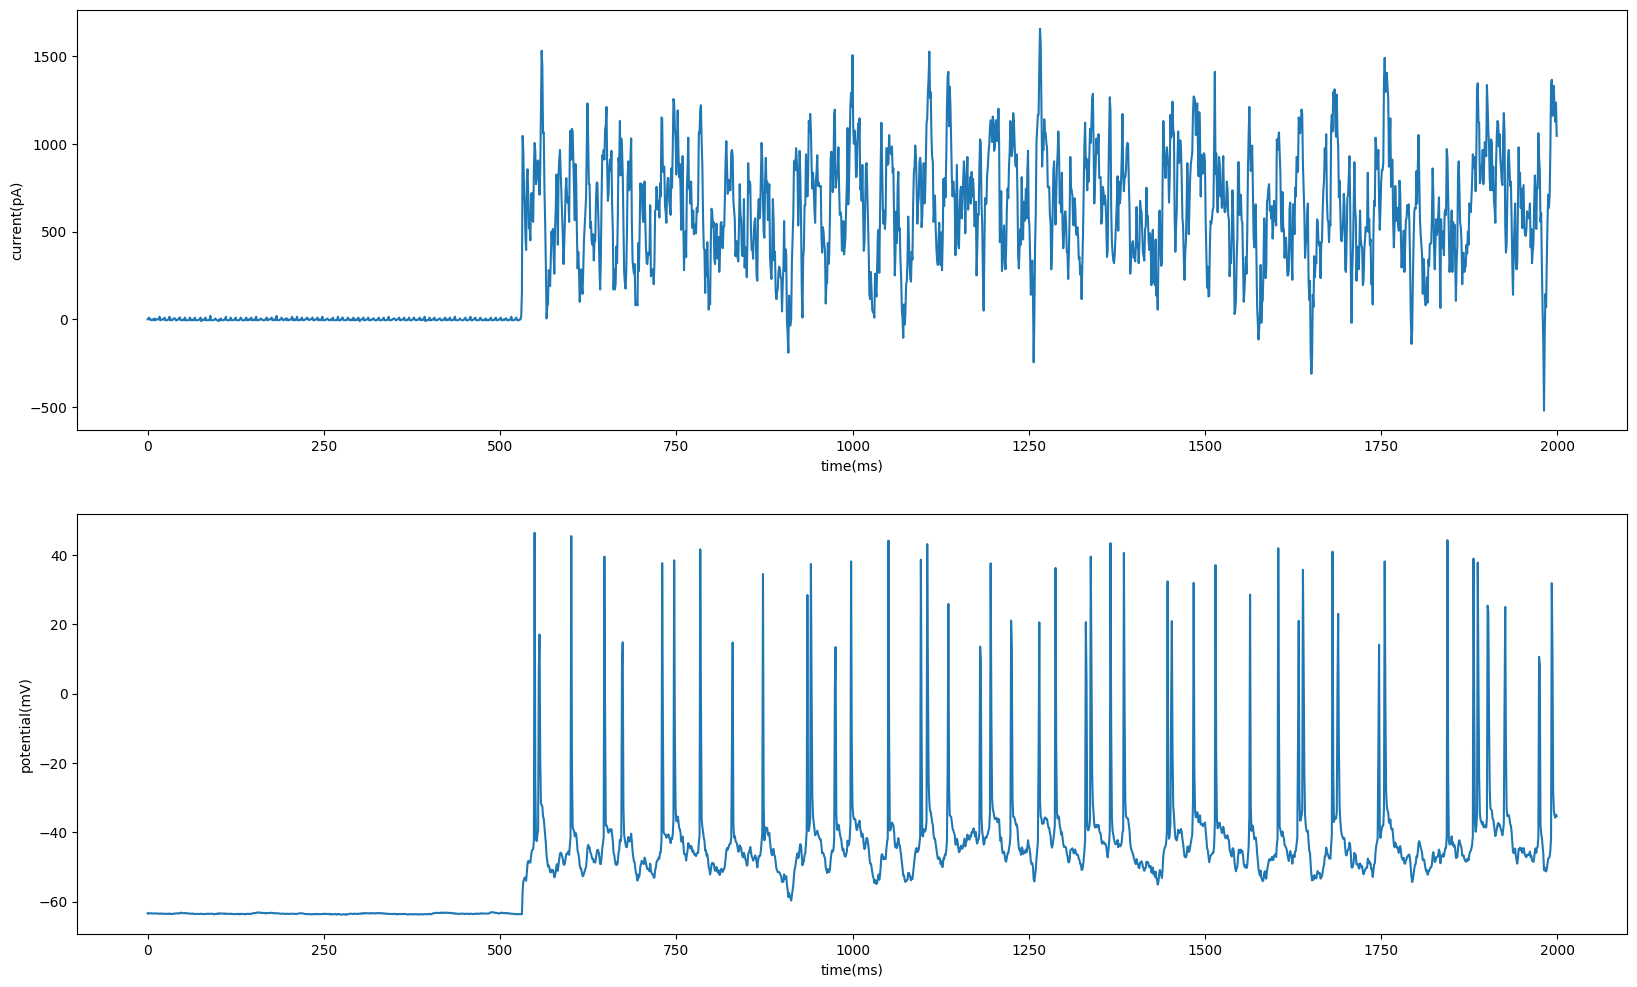

In [ ]:
time_3, i_3, voltage_3, spike_3 = load_and_visualize(3, end=2000)

In [ ]:
min(voltage_3)

tensor(-70.1172, dtype=torch.float64)

In [ ]:
model_3 = neup.ALIFPopulation(n=1, rest_pot=-63.3672, threshold=-70.1172, R=0.02, dt=1)

running_model(model_3, i_3, spike_3, time_3)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


In [ ]:
running_model(model, i_3, spike_3, time_3)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


first spike: 0.0 s 	 initial potential:-61.3672 mV 	 max pot and time: 49.2578 mV and 785 ms


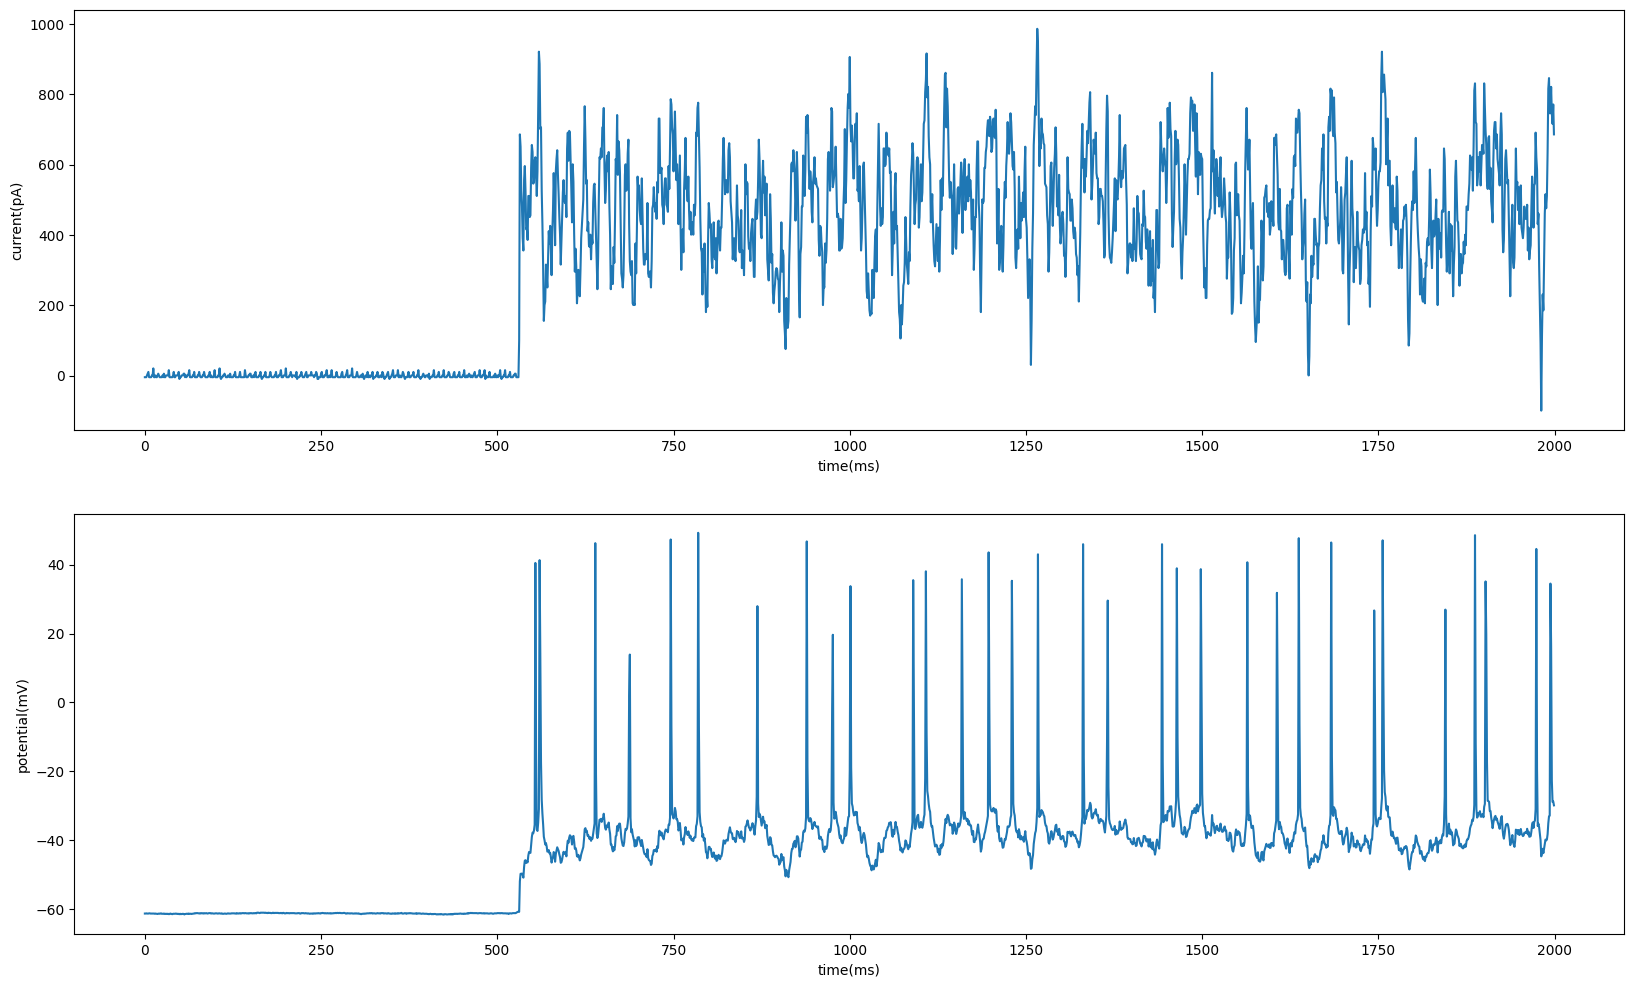

In [ ]:
time_6, i_6, voltage_6, spike_6 = load_and_visualize(6, end=2000)

In [ ]:
min(voltage_6)

tensor(-65.5547, dtype=torch.float64)

In [ ]:
model_6 = neup.AELIFPopulation(n=1, rest_pot=-61.3672, threshold=-65.5547, R=0.02, dt=1)

running_model(model_6, i_6, spike_6, time_6)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


In [ ]:
running_model(model, i_6, spike_6, time_6)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


first spike: 0.0 s 	 initial potential:-59.4922 mV 	 max pot and time: 47.8828 mV and 18307 ms


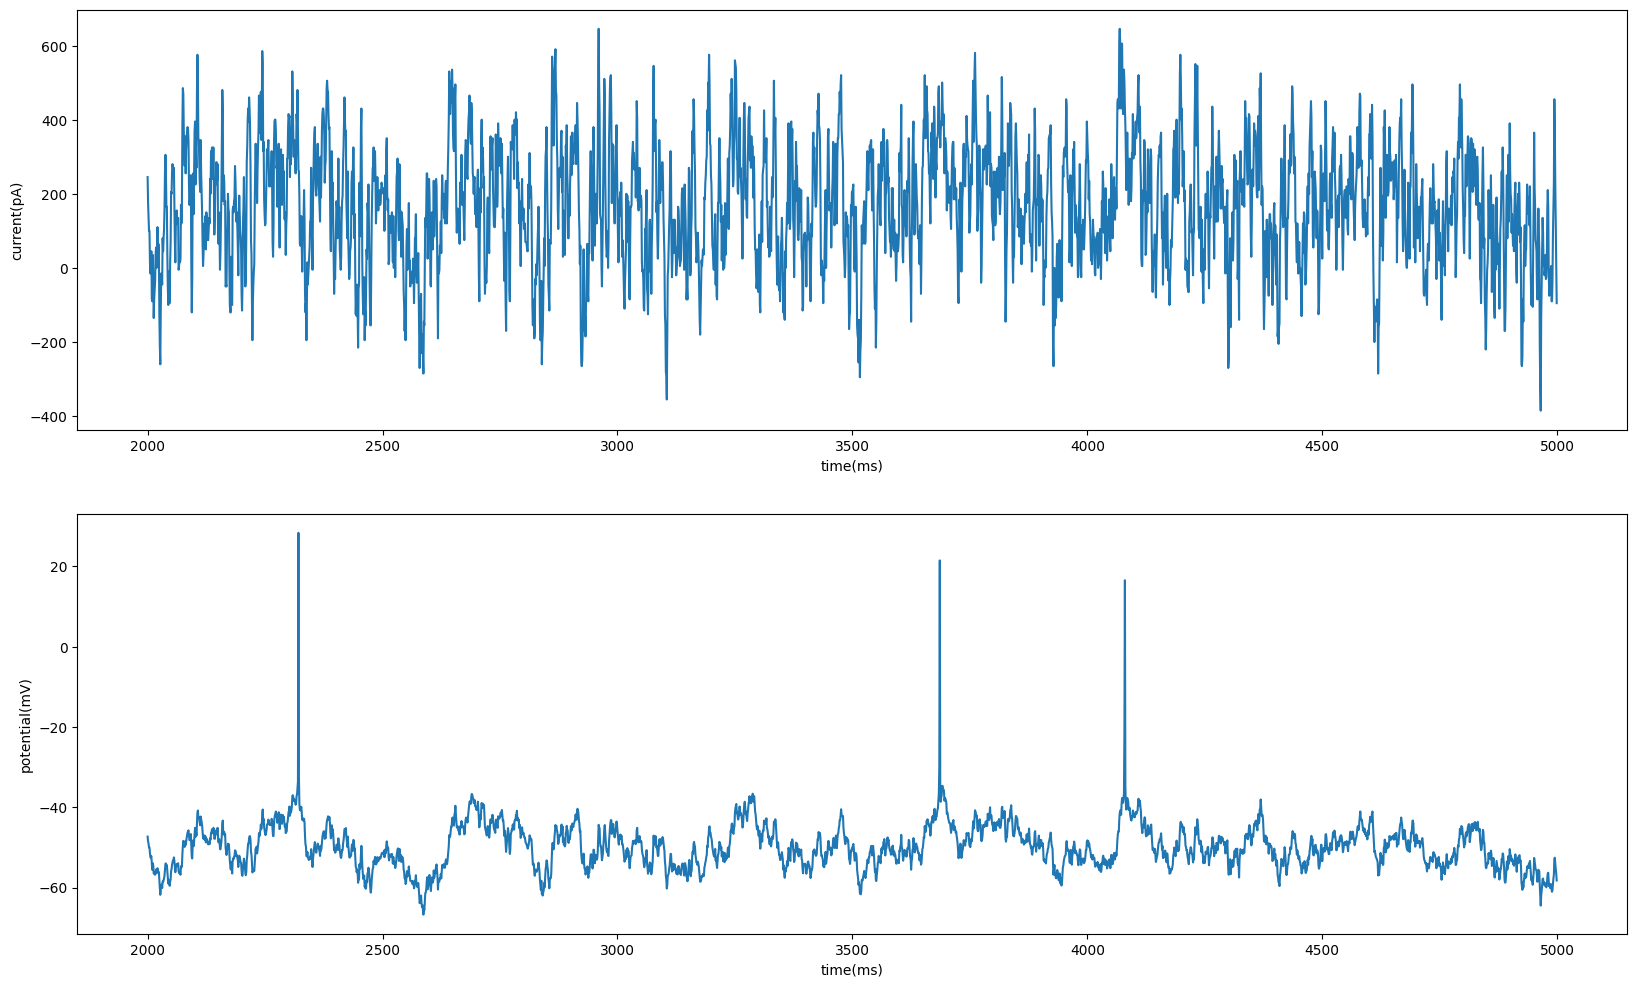

In [ ]:
time_9, i_9, voltage_9, spike_9 = load_and_visualize(9, 2000)

In [ ]:
min(voltage_9)

tensor(-69.4922, dtype=torch.float64)

In [ ]:
model_9 = neup.AQLIFPopulation(n=1, rest_pot=-59.4922, threshold=-69.4922, R=0.02, dt=1)

running_model(model_9, i_9, spike_9, time_9)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


In [ ]:
running_model(model, i_9, spike_9, time_9)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


first spike: 0.0 s 	 initial potential:-59.4922 mV 	 max pot and time: 48.0078 mV and 1137 ms


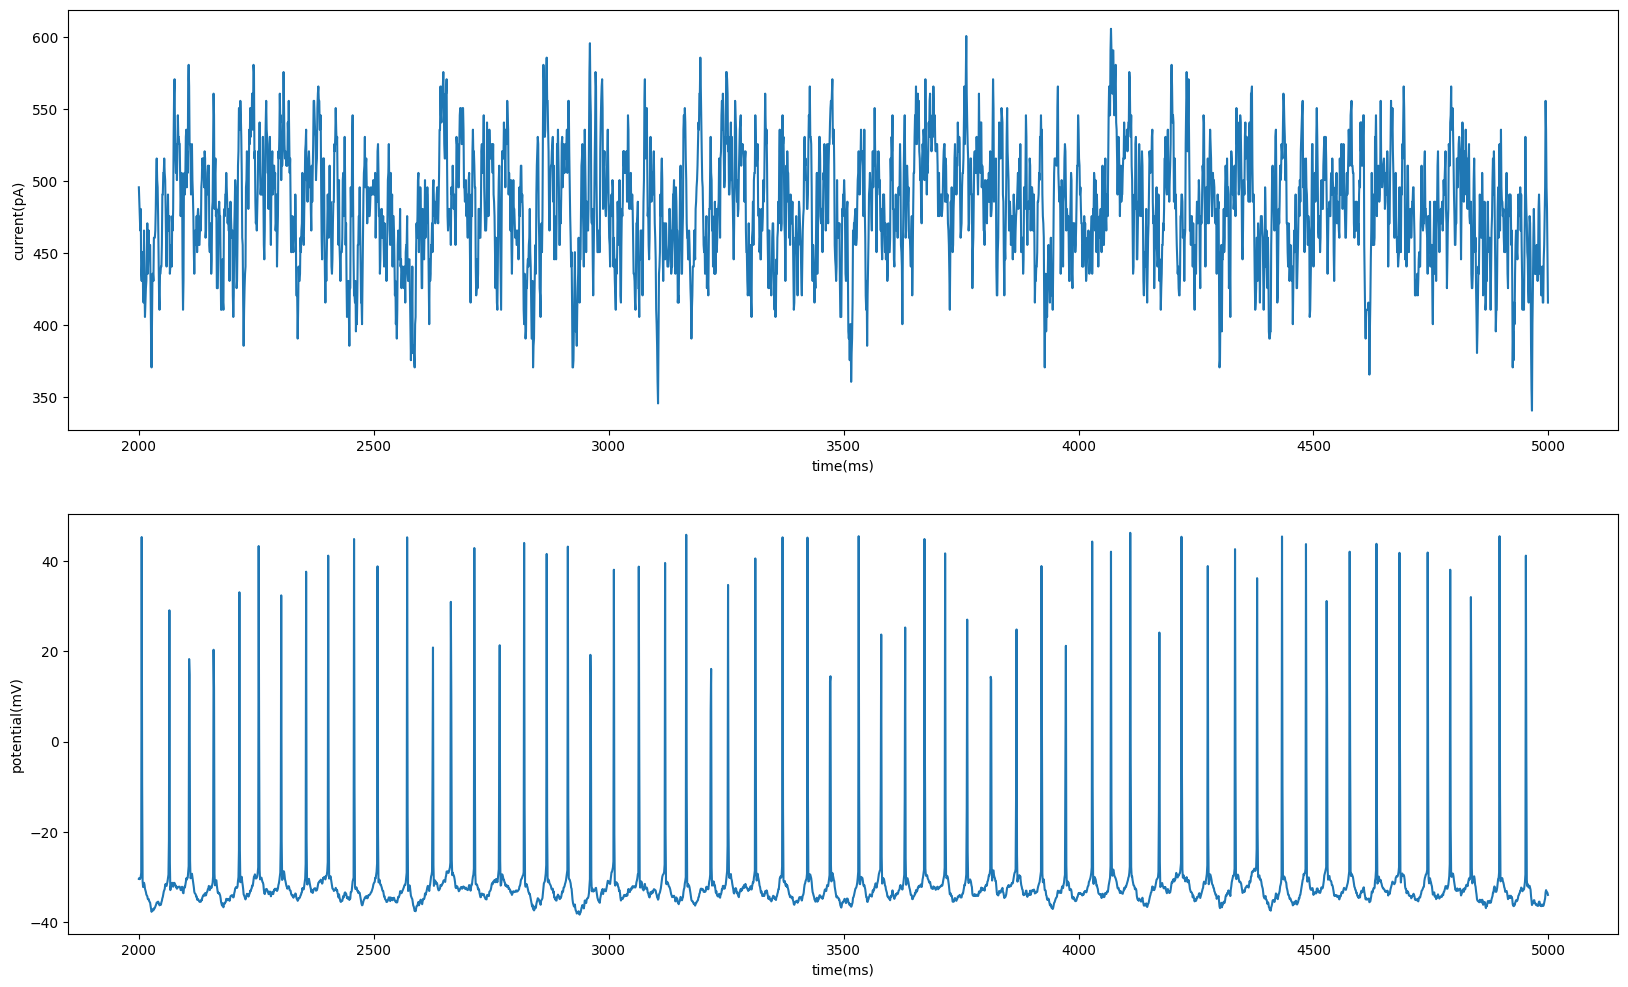

In [ ]:
time_12, i_12, voltage_12, spike_12 = load_and_visualize(12, 2000)

In [ ]:
min(voltage_12)

tensor(-63.0547, dtype=torch.float64)

In [ ]:
model_12 = neup.AQLIFPopulation(n=1, rest_pot=-59.4922, threshold=-63.0547, R=0.02, dt=1)

running_model(model_12, i_12, spike_12, time_12)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


In [ ]:
running_model(model, i_12, spike_12, time_12)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


first spike: 0.0 s 	 initial potential:-59.9922 mV 	 max pot and time: 47.3203 mV and 2245 ms


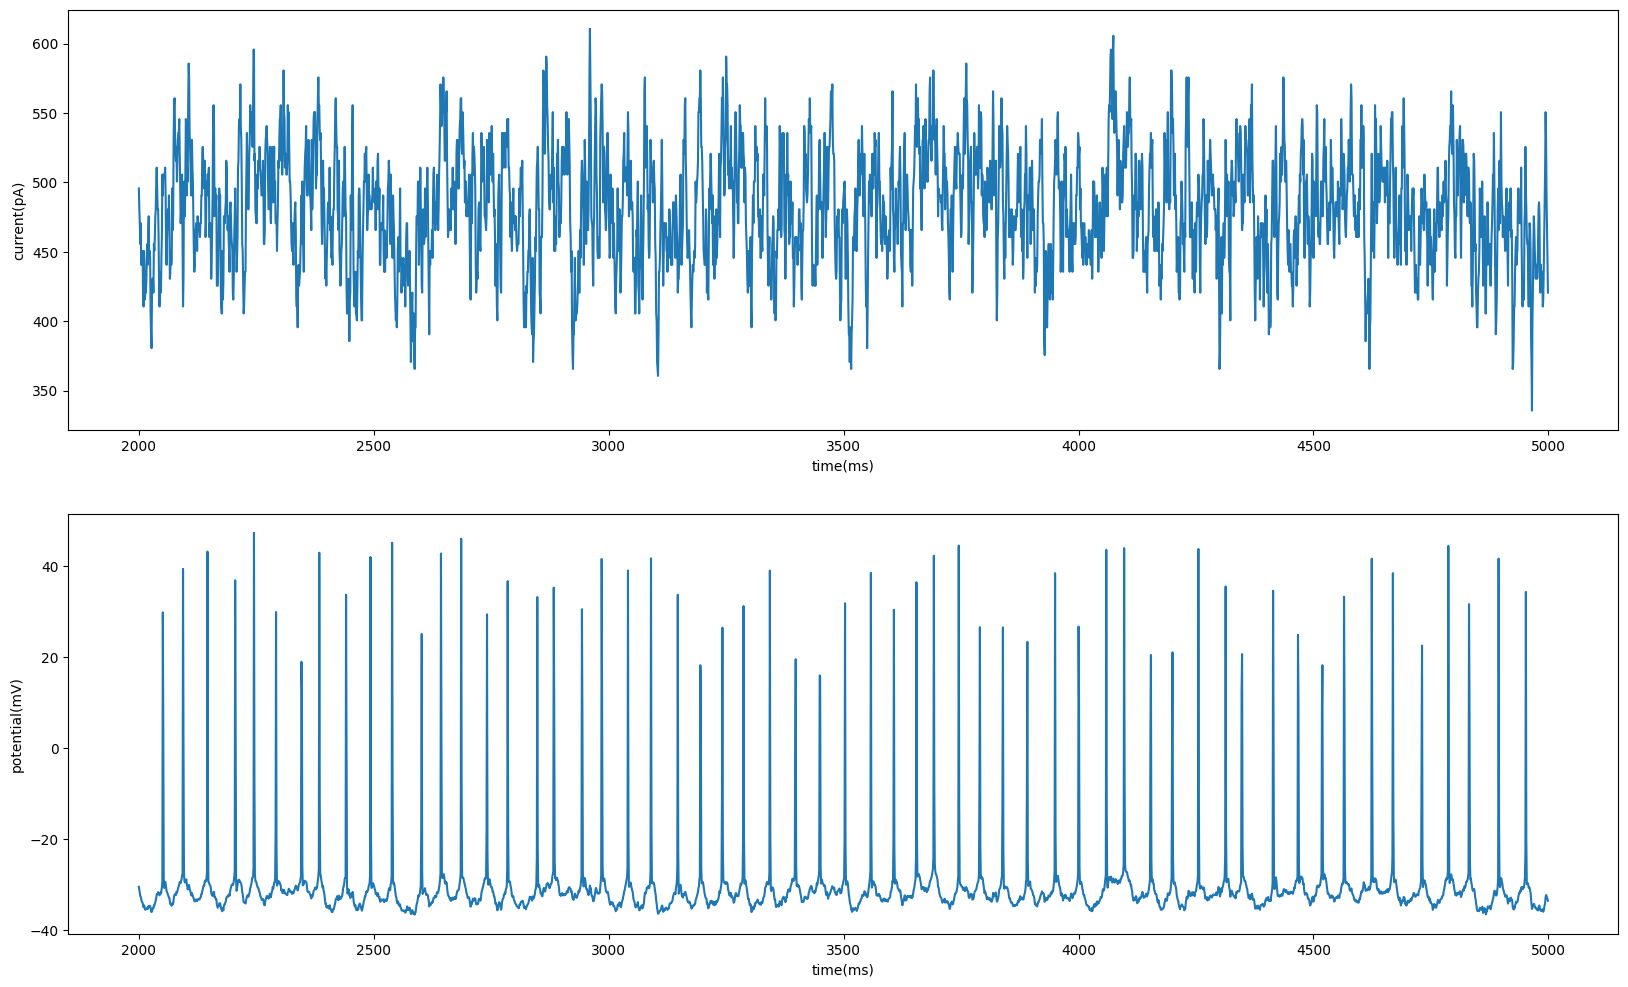

In [ ]:
time_15, i_15, voltage_15, spike_15 = load_and_visualize(15, 2000)

In [ ]:
min(voltage_15)

tensor(-62.6797, dtype=torch.float64)

In [ ]:
model_15 = neup.AQLIFPopulation(n=1, rest_pot=-59.9922, threshold=-62.6797, R=0.02, dt=1)

running_model(model_15, i_15, spike_15, time_15)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45


In [ ]:
running_model(model, i_15, spike_15, time_15)

machings: 34000	 real_spikes: 34000	 model_spikes: 34000
accuracy: 0.45
